In [2]:
import bisect
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
import seaborn as sns
from networkx.drawing.nx_pydot import graphviz_layout
# import pydot
from google.cloud import storage

import dalmatian 
from fludarabine import model_helper 
from fludarabine.helper import *
from scipy.stats import iqr

In [3]:
# Load wbc and treatment file 
wbc_df = pd.read_csv('../../../data/gcll/CLL8 CLL cell count 10282024 UPDATED.csv')
treatment = pd.read_csv("../../../data/gcll/GCLL_treatment.txt", sep = '\t')

# Get input files from Terra through dalmatian
patient = 'GCLL-0068'
workspace ='broad-firecloud-ibmwatson/TAG_CLL_Clonal_Kinetic_UMI_PrAN'
wm = dalmatian.WorkspaceManager(workspace)

participants = wm.get_participants()


cluster_CCF_df = pd.read_csv(participants.loc[patient]['cluster_ccfs'], sep='\t')

abundance_df = pd.read_csv(participants.loc[patient]['abundances_tsv'], sep='\t')
mcmc_df = pd.read_csv(participants.loc[patient]['cell_population_mcmc_trace'], sep='\t')
tree_df = pd.read_csv(participants.loc[patient]['tree_tsv'], sep='\t')

In [4]:
# Select the wbc data for the patient

In [5]:
wbc_df_0068 = wbc_df[wbc_df['Patient'] == patient]
sample_list = wbc_df_0068['Timepoint'].dropna().tolist()

times_sample = [ int(i) for i in wbc_df_0068.loc[wbc_df_0068.Sample.notna(), 'Time_since_start_tx'].tolist()]
CLL_count = [float(i) for i in wbc_df_0068.loc[wbc_df_0068.Sample.notna(),'CLL count estm'].tolist()]

In [6]:
CLL_count

[139.5, 0.069332, 0.41027373, 1.39188415, 8.3349]

In [7]:
times_sample

[-10, 814, 905, 996, 1081]

In [8]:
# Select the UMI timepoints with index
UMI_start = 1
UMI_end = 4

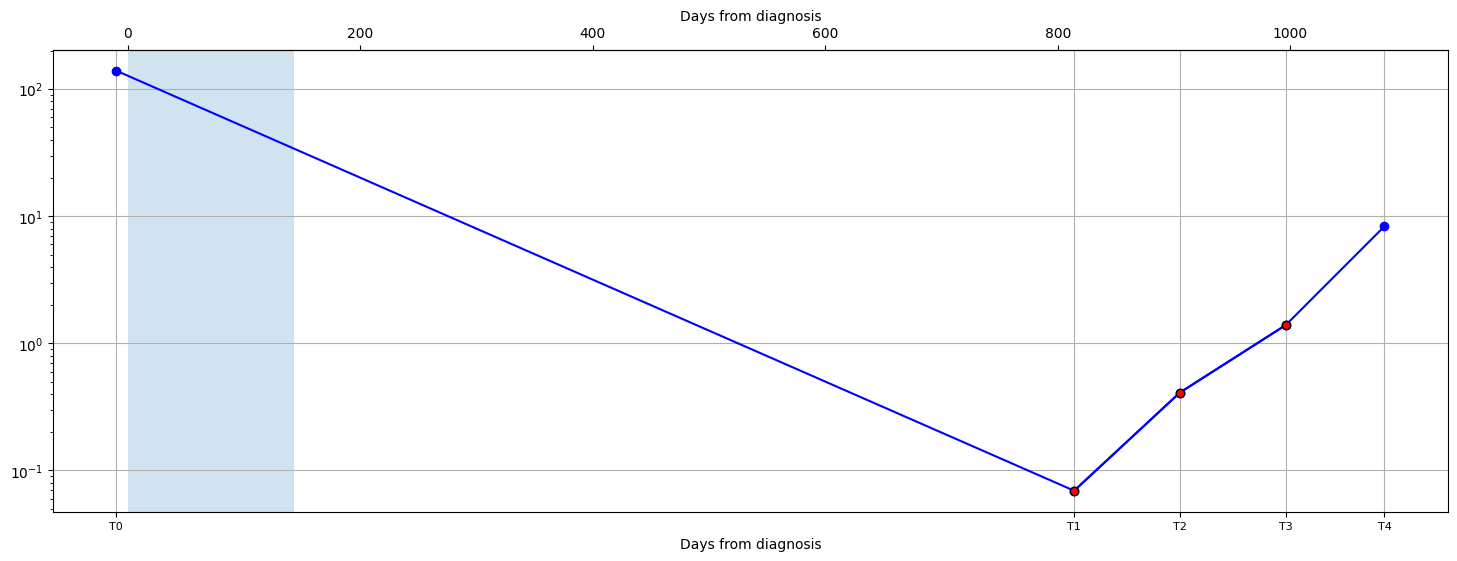

In [9]:
fig,ax = plt.subplots(1,1, figsize=(18,6))
ax.semilogy(times_sample,CLL_count,marker = 'o', color='blue')

# Create a scatter plot for the UMI timepoints with the red color
ax.semilogy(times_sample[UMI_start:UMI_end], CLL_count[UMI_start:UMI_end], color='blue',markerfacecolor='red',mec='black', marker = 'o')


# Fludarabine treatment 
ax.axvspan(xmin = 0, xmax= 143, label = "Fludarabine", alpha = 0.2)
ax.set_xlabel('Days from diagnosis')


number_samples = len(sample_list)
tick_list = ['T'+ str(i) for i in range(number_samples)]
ax.set_xticks(times_sample)
ax.set_xticklabels(tick_list, fontsize =8)

secax = ax.secondary_xaxis('top')
secax.set_xlabel('Days from diagnosis')
ax.grid(True)

Subclonal modeling

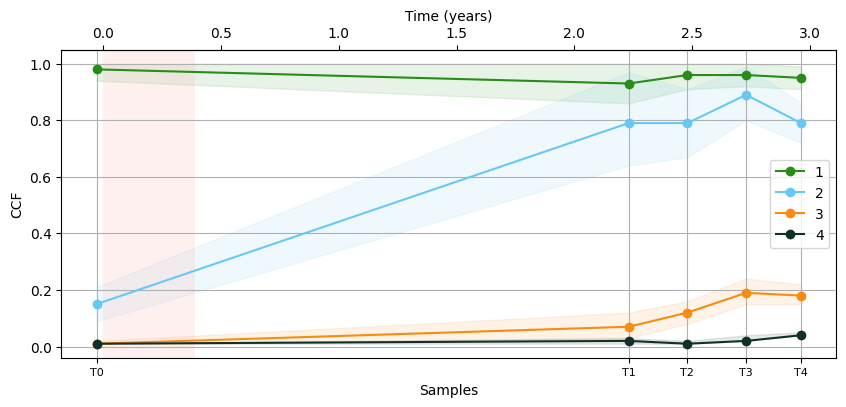

In [10]:
fig, ax = plt.subplots(figsize = (10, 4))
model_helper.plot_ccf(cluster_CCF_df,ax, times_sample, treatment)

In [11]:
abundance_df.Sample_ID.unique()

array(['GCLL-0068-T-01',
       'RP-1895_PDO-33508_SM-NKK1G_GCLL-0068-MRD-01_v1_Custom_Selection_OnPrem',
       'RP-1895_PDO-33508_SM-NKK12_GCLL-0068-MRD-03_v1_Custom_Selection_OnPrem',
       'RP-1895_PDO-33508_SM-NKK1P_GCLL-0068-MRD-02_v1_Custom_Selection_OnPrem',
       'GCLL-0068-T-02'], dtype=object)

In [12]:
# Manually verify the sample list order is correct

In [13]:
sample_list = ['GCLL-0068-T-01','RP-1895_PDO-33508_SM-NKK1G_GCLL-0068-MRD-01_v1_Custom_Selection_OnPrem','RP-1895_PDO-33508_SM-NKK1P_GCLL-0068-MRD-02_v1_Custom_Selection_OnPrem',
               'RP-1895_PDO-33508_SM-NKK12_GCLL-0068-MRD-03_v1_Custom_Selection_OnPrem',
 'GCLL-0068-T-02']

In [14]:
cluster_list, cluster_abundance = model_helper.get_abundance(abundance_df, mcmc_df, sample_list)

In [15]:
cluster_list

[1, 2, 3, 4]

In [16]:
cluster_abundance

{1: [0.85, 0.12, 0.21, 0.16, 0.15],
 2: [0.13, 0.68, 0.62, 0.64, 0.6],
 3: [0.01, 0.06, 0.1, 0.17, 0.17],
 4: [0.01, 0.04, 0.01, 0.02, 0.04]}

In [17]:
# calculate only at sample points
subclone_sample, log_subclone_sample = model_helper.calc_subclone(CLL_count, cluster_abundance, cluster_list)


In [18]:
all_abundance = model_helper.get_all_abundance(cluster_list, mcmc_df, sample_list, times_sample, )

In [19]:
#  Add noise to all abundance

import random 

def add_uniform_noise_and_normalize(lst, low=0, high=0.01):
    
    # Add uniform noise
    noisy_lst = [x + random.uniform(low, high) for x in lst]

    
    # Normalize the list
    total_sum = sum(noisy_lst)
    
    normalized_lst = [x / total_sum for x in noisy_lst]

    return normalized_lst


subclone_cluster_iter = {}
# Iterate through each cluster
for cluster, iterations in all_abundance.items():
   
    # Iterate through each iteration in the cluster
    for iteration, value in iterations.items():
        # If the iteration is not in the new dict, add it
        if iteration not in subclone_cluster_iter:
            subclone_cluster_iter[iteration] = {}
        # Add the cluster and its value to this iteration
        subclone_cluster_iter[iteration][cluster] = value

        
        
noise_added_iter = {}

for iteration, abundances in subclone_cluster_iter.items():
    
    transposed_data = {i: list(values) for i, values in enumerate(zip(*abundances.values()), start=1)}
    
    noise_added_iter[iteration] = {}
    for time_point, abundance in transposed_data.items():
        
#         print(time_point, abundance)
        noise_abundance = add_uniform_noise_and_normalize(abundance)
    
#         print(noise_abundance)

        noise_added_iter[iteration][time_point] = add_uniform_noise_and_normalize(abundance)

    
noise_added_all_abundance = {}
for iteration, abundances in noise_added_iter.items():
    original_format = {i + 1: list(values) for i, values in enumerate(zip(*abundances.values()))}
    noise_added_all_abundance[iteration] = original_format
    
    
noise_added_original_all_abundances = {}

for iteration, abundances in noise_added_all_abundance.items():
    
    for cluster, abundance_value in abundances.items():
        if cluster not in noise_added_original_all_abundances:
            noise_added_original_all_abundances[cluster] = {}
        noise_added_original_all_abundances[cluster][iteration] = abundance_value
            

In [20]:
all_abundance

{1: {0: [0.84, 0.13, 0.17, 0.17, 0.25],
  1: [0.83, 0.0, 0.03, 0.0, 0.23],
  2: [0.86, 0.0, 0.16, 0.14, 0.24],
  3: [0.81, 0.06, 0.08, 0.25, 0.08],
  4: [0.84, 0.2, 0.18, 0.08, 0.14],
  5: [0.84, 0.0, 0.26, 0.07, 0.05],
  6: [0.81, 0.18, 0.13, 0.11, 0.23],
  7: [0.85, 0.17, 0.04, 0.1, 0.1],
  8: [0.84, 0.22, 0.09, 0.11, 0.16],
  9: [0.75, 0.15, 0.17, 0.05, 0.25],
  10: [0.87, 0.23, 0.18, 0.19, 0.27],
  11: [0.81, 0.17, 0.18, 0.0, 0.22],
  12: [0.75, 0.08, 0.14, 0.0, 0.14],
  13: [0.81, 0.21, 0.07, 0.03, 0.17],
  14: [0.79, 0.31, 0.12, 0.12, 0.24],
  15: [0.85, 0.0, 0.35, 0.09, 0.13],
  16: [0.76, 0.1, 0.24, 0.13, 0.21],
  17: [0.85, 0.05, 0.09, 0.19, 0.09],
  18: [0.88, 0.12, 0.19, 0.12, 0.11],
  19: [0.77, 0.0, 0.13, 0.03, 0.12],
  20: [0.88, 0.21, 0.12, 0.16, 0.13],
  21: [0.79, 0.08, 0.19, 0.13, 0.06],
  22: [0.86, 0.16, 0.19, 0.07, 0.14],
  23: [0.84, 0.13, 0.24, 0.02, 0.16],
  24: [0.84, 0.01, 0.09, 0.12, 0.14],
  25: [0.85, 0.26, 0.17, 0.0, 0.06],
  26: [0.81, 0.11, 0.03, 0.05, 0

In [21]:
noise_added_original_all_abundances

{1: {0: [0.8644309401179531,
   0.1368960156562395,
   0.18233298836935216,
   0.18764059947677783,
   0.2552469523879961],
  1: [0.8465362924594306,
   0.009954122103150442,
   0.04182714952785,
   0.006966564985271377,
   0.23013077102501694],
  2: [0.8553040527379692,
   0.0009825812575131616,
   0.173530109839039,
   0.14650650239769372,
   0.24976374080060418],
  3: [0.7957454823917938,
   0.06197239505400786,
   0.08678686503684332,
   0.24807340465103603,
   0.08911221607945179],
  4: [0.824530093384743,
   0.20066480622872257,
   0.19671804116882938,
   0.08984530992573973,
   0.14333915570105502],
  5: [0.8528134409530113,
   0.001106297370068654,
   0.27421328377273385,
   0.08126633983060637,
   0.056893072217882486],
  6: [0.8044152590541235,
   0.1922296157910537,
   0.13400703511072778,
   0.11335770835238339,
   0.23600066886320656],
  7: [0.8813159647088812,
   0.1902616079626251,
   0.04811312313729674,
   0.10858192308380507,
   0.1151710885076285],
  8: [0.8312290115

In [22]:
subclone_sample_mcmc_with_uniform_noise, log_subclone_sample_mcmc_with_uniform_noise = model_helper.calc_subclone(CLL_count, noise_added_original_all_abundances, cluster_list, input_type = "mcmc")

In [23]:
times_sample

[-10, 814, 905, 996, 1081]

In [24]:
# Get the times at the start of the treatment and after 
all_times = [int(i) for i in wbc_df_0068['Time_since_start_tx'].to_list()]

times_aft_tx = [x for x in all_times if x > 143]
times_aft_tx.insert(0, 143)

In [25]:
# Get the times after treatment but before the first sample after treatment
times_for_wbc_est = [x for x in all_times if x > 143 and x <814]
times_for_wbc_est

[177, 233, 317, 415, 499, 597, 681]

In [26]:
times_aft_tx

[143, 177, 233, 317, 415, 499, 597, 681, 814, 905, 996, 1081]

In [27]:
# Linear Regression Modeling

In [28]:
CLL_count

[139.5, 0.069332, 0.41027373, 1.39188415, 8.3349]

In [29]:
# Set the extrapolate time after treatment
extrapolate_start_idx = 1
# extrapolate_end_idx = 6

extrapolate_times =times_sample[extrapolate_start_idx:]

In [30]:
extrapolate_times

[814, 905, 996, 1081]

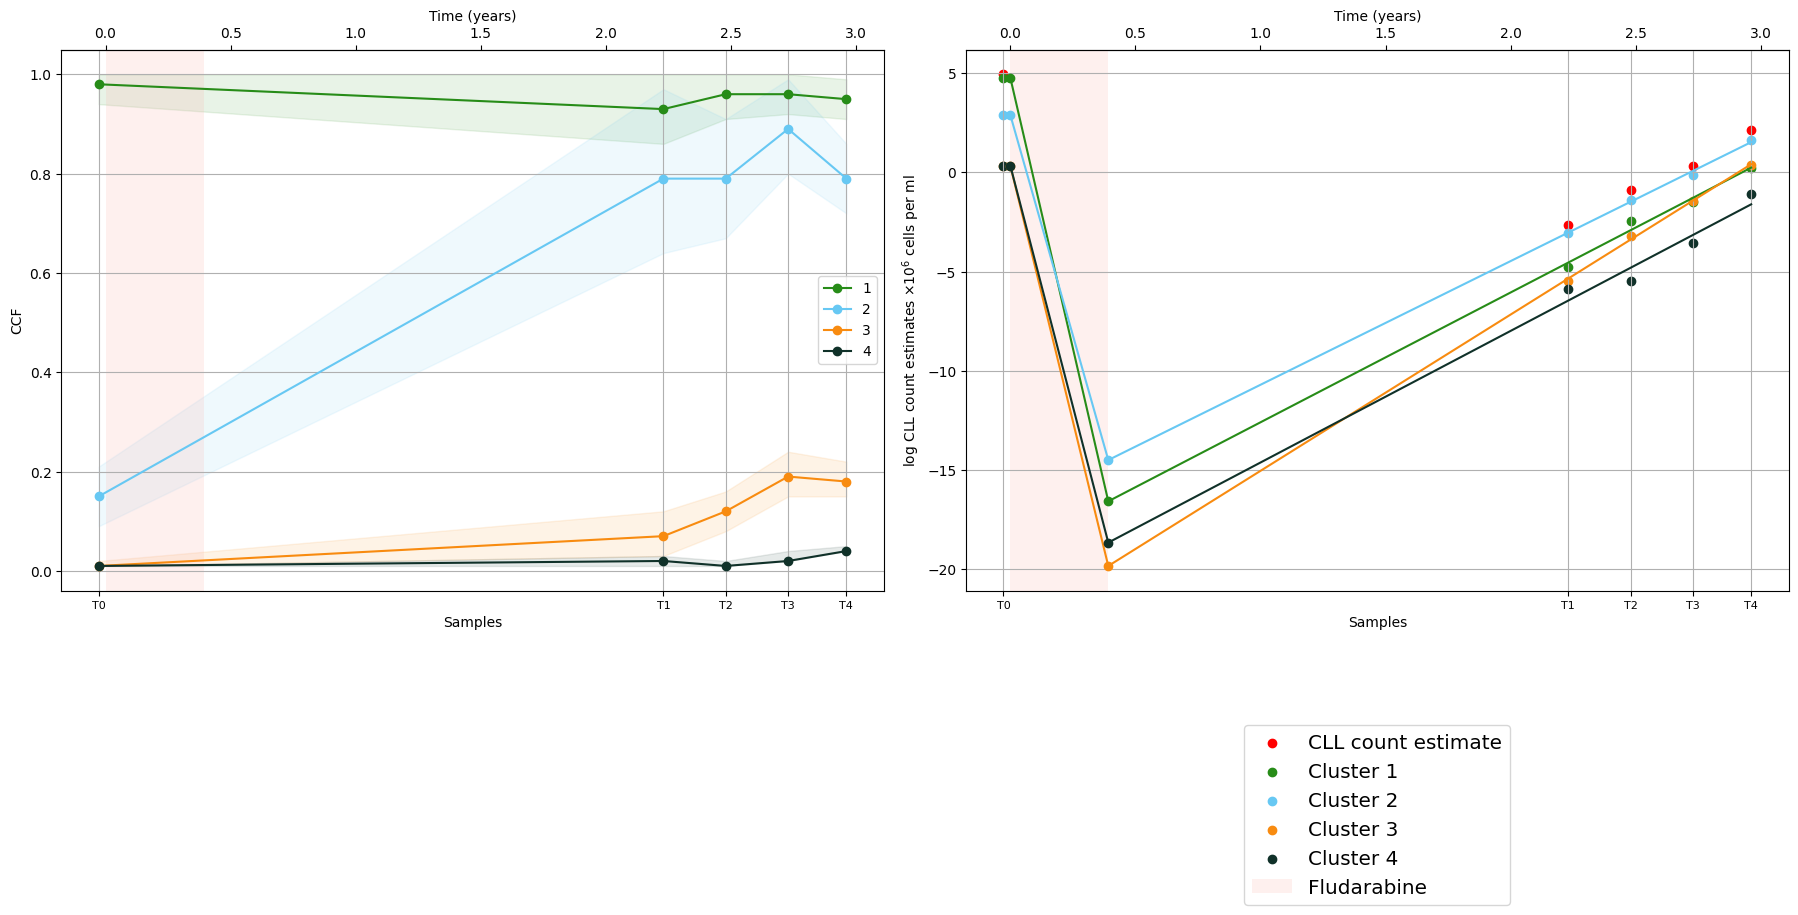

In [31]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]

predicted_end_tx_clones = []

def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year = [ i/365 for i in np.array(times_sample)]
    ax.scatter(x_year,np.log(CLL_count), label = 'CLL count estimate', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}
    
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)


        # Extrapolate after treatment
        extrapolate_times =times_sample[extrapolate_start_idx:]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = log_subclone_sample[i][extrapolate_start_idx:]
        
        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_aft_tx
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        
        predicted_end_tx_clones.append(predicted[0])
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))


    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log CLL count estimates $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_sub(ax2, [1,2,3, 4])
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')




## Assume exponential decrease during treatment and constant subclonal composition before treatment 

 
times_during_tx = [0,143/365]

tx_start_clones=[]
clusters = [1,2,3, 4]
for i in clusters:
    tx_start_clones.append(log_subclone_sample[i][0])




for i in clusters:
    ax2.plot(times_during_tx, [tx_start_clones[i-1], predicted_end_tx_clones[i-1]], color=ClusterColors.get_hex_string(i), marker = 'o')




In [32]:
# Estimating total wbc after treatment using logsumexp

In [33]:
from scipy.special import logsumexp

[1.0395410075714503e-06, 2.7261022711352817e-06, 1.1591426254168253e-05, 6.288362684395108e-05, 0.0002686564519477863, 0.0014683400525299488, 0.0063275607277701795]


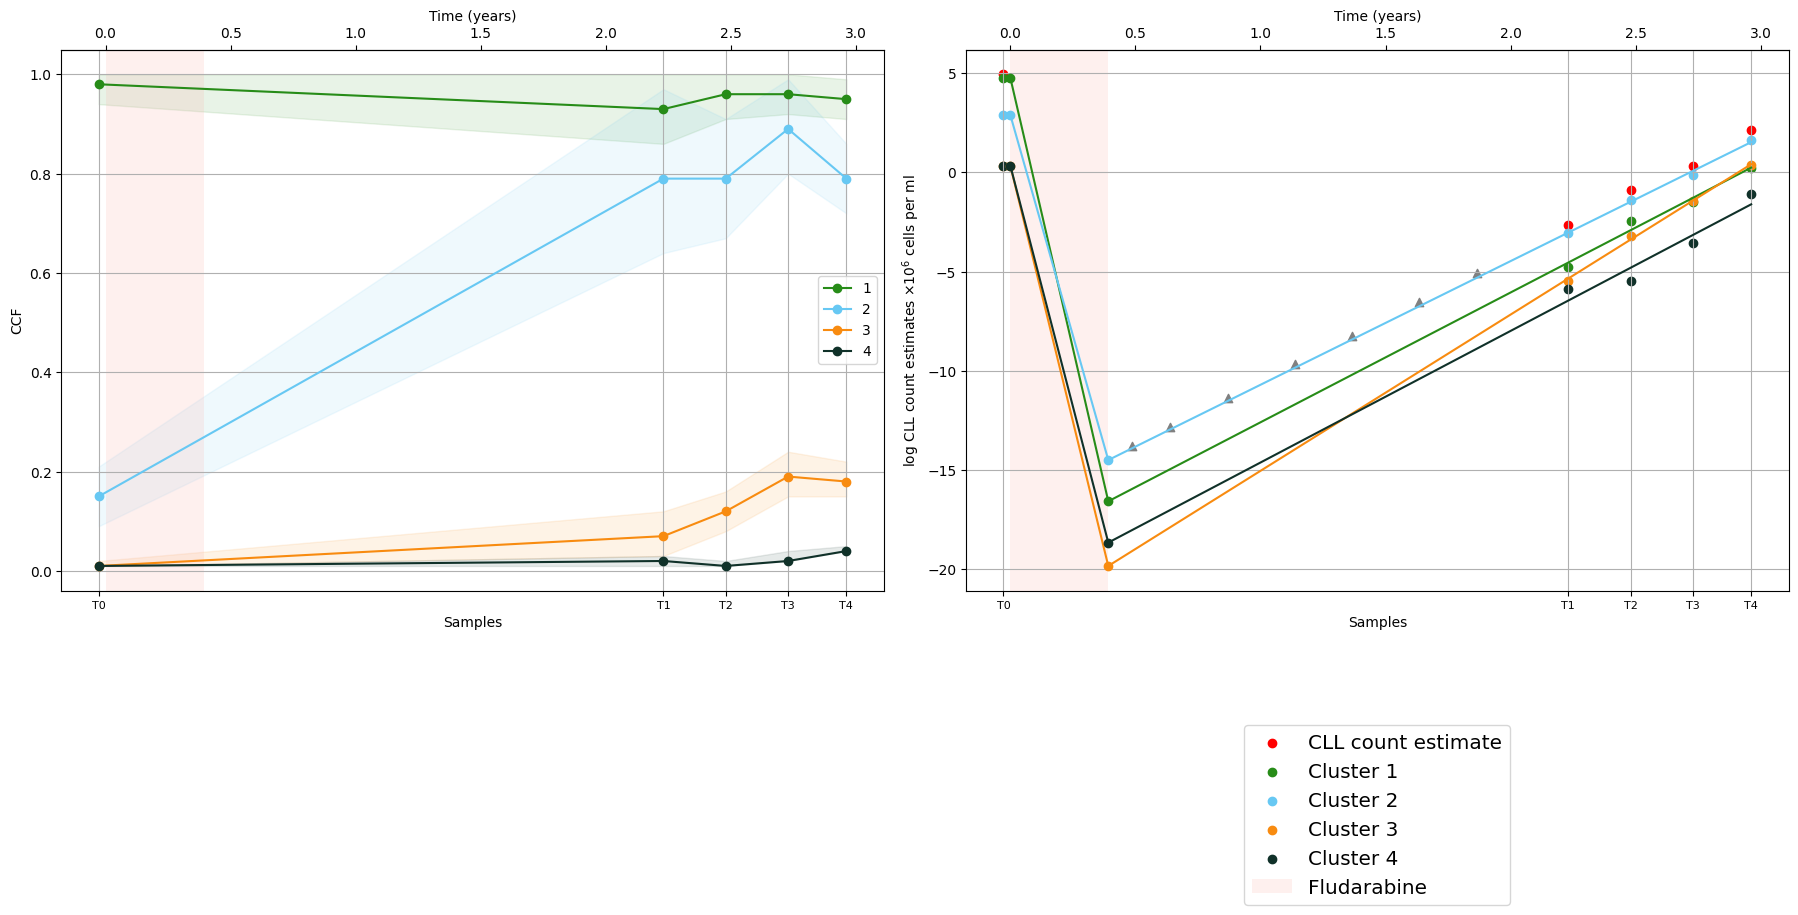

In [34]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]

predicted_end_tx_clones = []

def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year = [ i/365 for i in np.array(times_sample)]
    ax.scatter(x_year,np.log(CLL_count), label = 'CLL count estimate', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}
    
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)


        # Extrapolate after treatment
        extrapolate_times =times_sample[extrapolate_start_idx:]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = log_subclone_sample[i][extrapolate_start_idx:]
        
        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_aft_tx
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        
        ## for wbc prediction after treatment
        times_for_wbc_est_year = [ i/365 for i in np.array(times_for_wbc_est)]
        cluster_cell_population[i] = np.polyval(model,times_for_wbc_est_year)
        
        
        predicted_end_tx_clones.append(predicted[0])
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))

    ## Adding predicted wbc after treatment
   
    wbc_predicted =[]
    for timepoint in range(len(times_for_wbc_est)):
        predicted_all_subclone =[]
        for cluster in clusters:
            predicted_subclone = cluster_cell_population[cluster][timepoint]
            predicted_all_subclone.append(predicted_subclone)
        
        wbc_predicted.append(logsumexp(predicted_all_subclone))
        
    wbc_original = [ np.exp(i) for i in wbc_predicted]
    print(wbc_original)
    
    
    
    plt.scatter(times_for_wbc_est_year, wbc_predicted, color='grey',marker='^', alpha = 1)
    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log CLL count estimates $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    
    return wbc_original
    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_sub(ax2, [1,2,3, 4])
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')




## Assume exponential decrease during treatment and constant subclonal composition before treatment 

 
times_during_tx = [0,143/365]

tx_start_clones=[]
clusters = [1,2,3, 4]
for i in clusters:
    tx_start_clones.append(log_subclone_sample[i][0])




for i in clusters:
    ax2.plot(times_during_tx, [tx_start_clones[i-1], predicted_end_tx_clones[i-1]], color=ClusterColors.get_hex_string(i), marker = 'o')




In [35]:
def estiamte_wbc_df (wbc_df_patient):
    wbc_df_patient = wbc_df[wbc_df['Patient'] == patient]

    wbc_original = plot_sub(ax2, [1,2,3, 4])


    wbc_df_patient = wbc_df_patient.reset_index()

    wbc_df_patient.loc[1:7, 'Estimated_CLL_extrap'] = wbc_original

    wbc_df_patient['MRD'] = wbc_df_patient['MRD'].astype(float)
    wbc_df_patient.loc[1:7, 'Estimated_WBC_extrap'] = wbc_df_patient['Estimated_CLL_extrap']/wbc_df_patient['MRD'] 

    return wbc_df_patient



[1.0395410075714503e-06, 2.7261022711352817e-06, 1.1591426254168253e-05, 6.288362684395108e-05, 0.0002686564519477863, 0.0014683400525299488, 0.0063275607277701795]


,index,Pt no.,Patient,Date of diagnosis,Date of treatment,Date of sample,Time_since_start_tx,WBC,MRD,MRD negative,CLL count estm,Timepoint,Sample,Estimated_CLL_extrap,Estimated_WBC_extrap
0,178,17.0,GCLL-0068,1/16/06,3/6/06,2/24/06,-10,150.00,0.930000,0.0,139.50000000,GCLL-0068-T-01,CLL-GCLL-0068-Tumor-SM-41JNW,NaN,NaN
1,179,17.0,GCLL-0068,1/16/06,3/6/06,8/30/06,177,4.60,0.000356,0.0,0.00163677,NaN,NaN,0.000001,0.002922
2,180,17.0,GCLL-0068,1/16/06,3/6/06,10/25/06,233,4.60,0.000304,0.0,0.00140007,NaN,NaN,0.000003,0.008957
3,181,17.0,GCLL-0068,1/16/06,3/6/06,1/17/07,317,4.60,0.000422,0.0,0.00194109,NaN,NaN,0.000012,0.027469
4,182,17.0,GCLL-0068,1/16/06,3/6/06,4/25/07,415,4.60,0.000338,0.0,0.00155547,NaN,NaN,0.000063,0.185967
5,183,17.0,GCLL-0068,1/16/06,3/6/06,7/18/07,499,4.60,0.000320,0.0,0.00147301,NaN,NaN,0.000269,0.838976
6,184,17.0,GCLL-0068,1/16/06,3/6/06,10/24/07,597,4.60,0.000840,0.0,0.00386180,NaN,NaN,0.001468,1.749021
7,185,17.0,GCLL-0068,1/16/06,3/6/06,1/16/08,681,4.60,0.002521,0.0,0.01159554,NaN,NaN,0.006328,2.510170
8,186,17.0,GCLL-0068,1/16/06,3/6/06,5/28/08,814,4.60,0.015072,0.0,0.06933200,GCLL-0068-MRD-01,CLL-GCLL-0068-Tumor-SM-7C9BS,NaN,NaN
9,187,17.0,GCLL-0068,1/16/06,3/6/06,8/27/08,905,5.10,0.080446,0.0,0.41027373,GCLL-0068-MRD-02,CLL-GCLL-0068-Tumor-SM-7C9BT,NaN,NaN


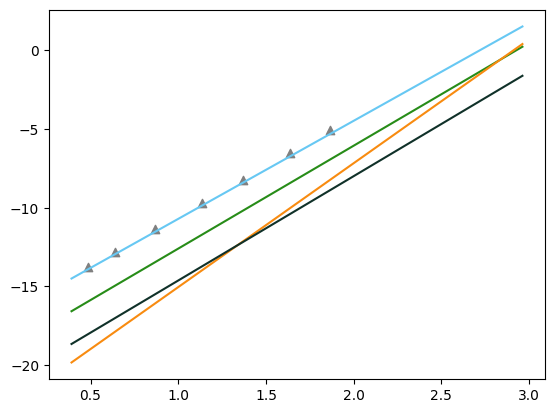

In [36]:
estiamte_wbc_df(wbc_df_0068)

In [37]:
# Adding all the iterations

In [38]:
subclone_sample_mcmc_with_uniform_noise[1][0]

[120.60206614645445,
 0.009498207757478396,
 0.07484746261334073,
 0.26131316472322536,
 2.1282913134587087]

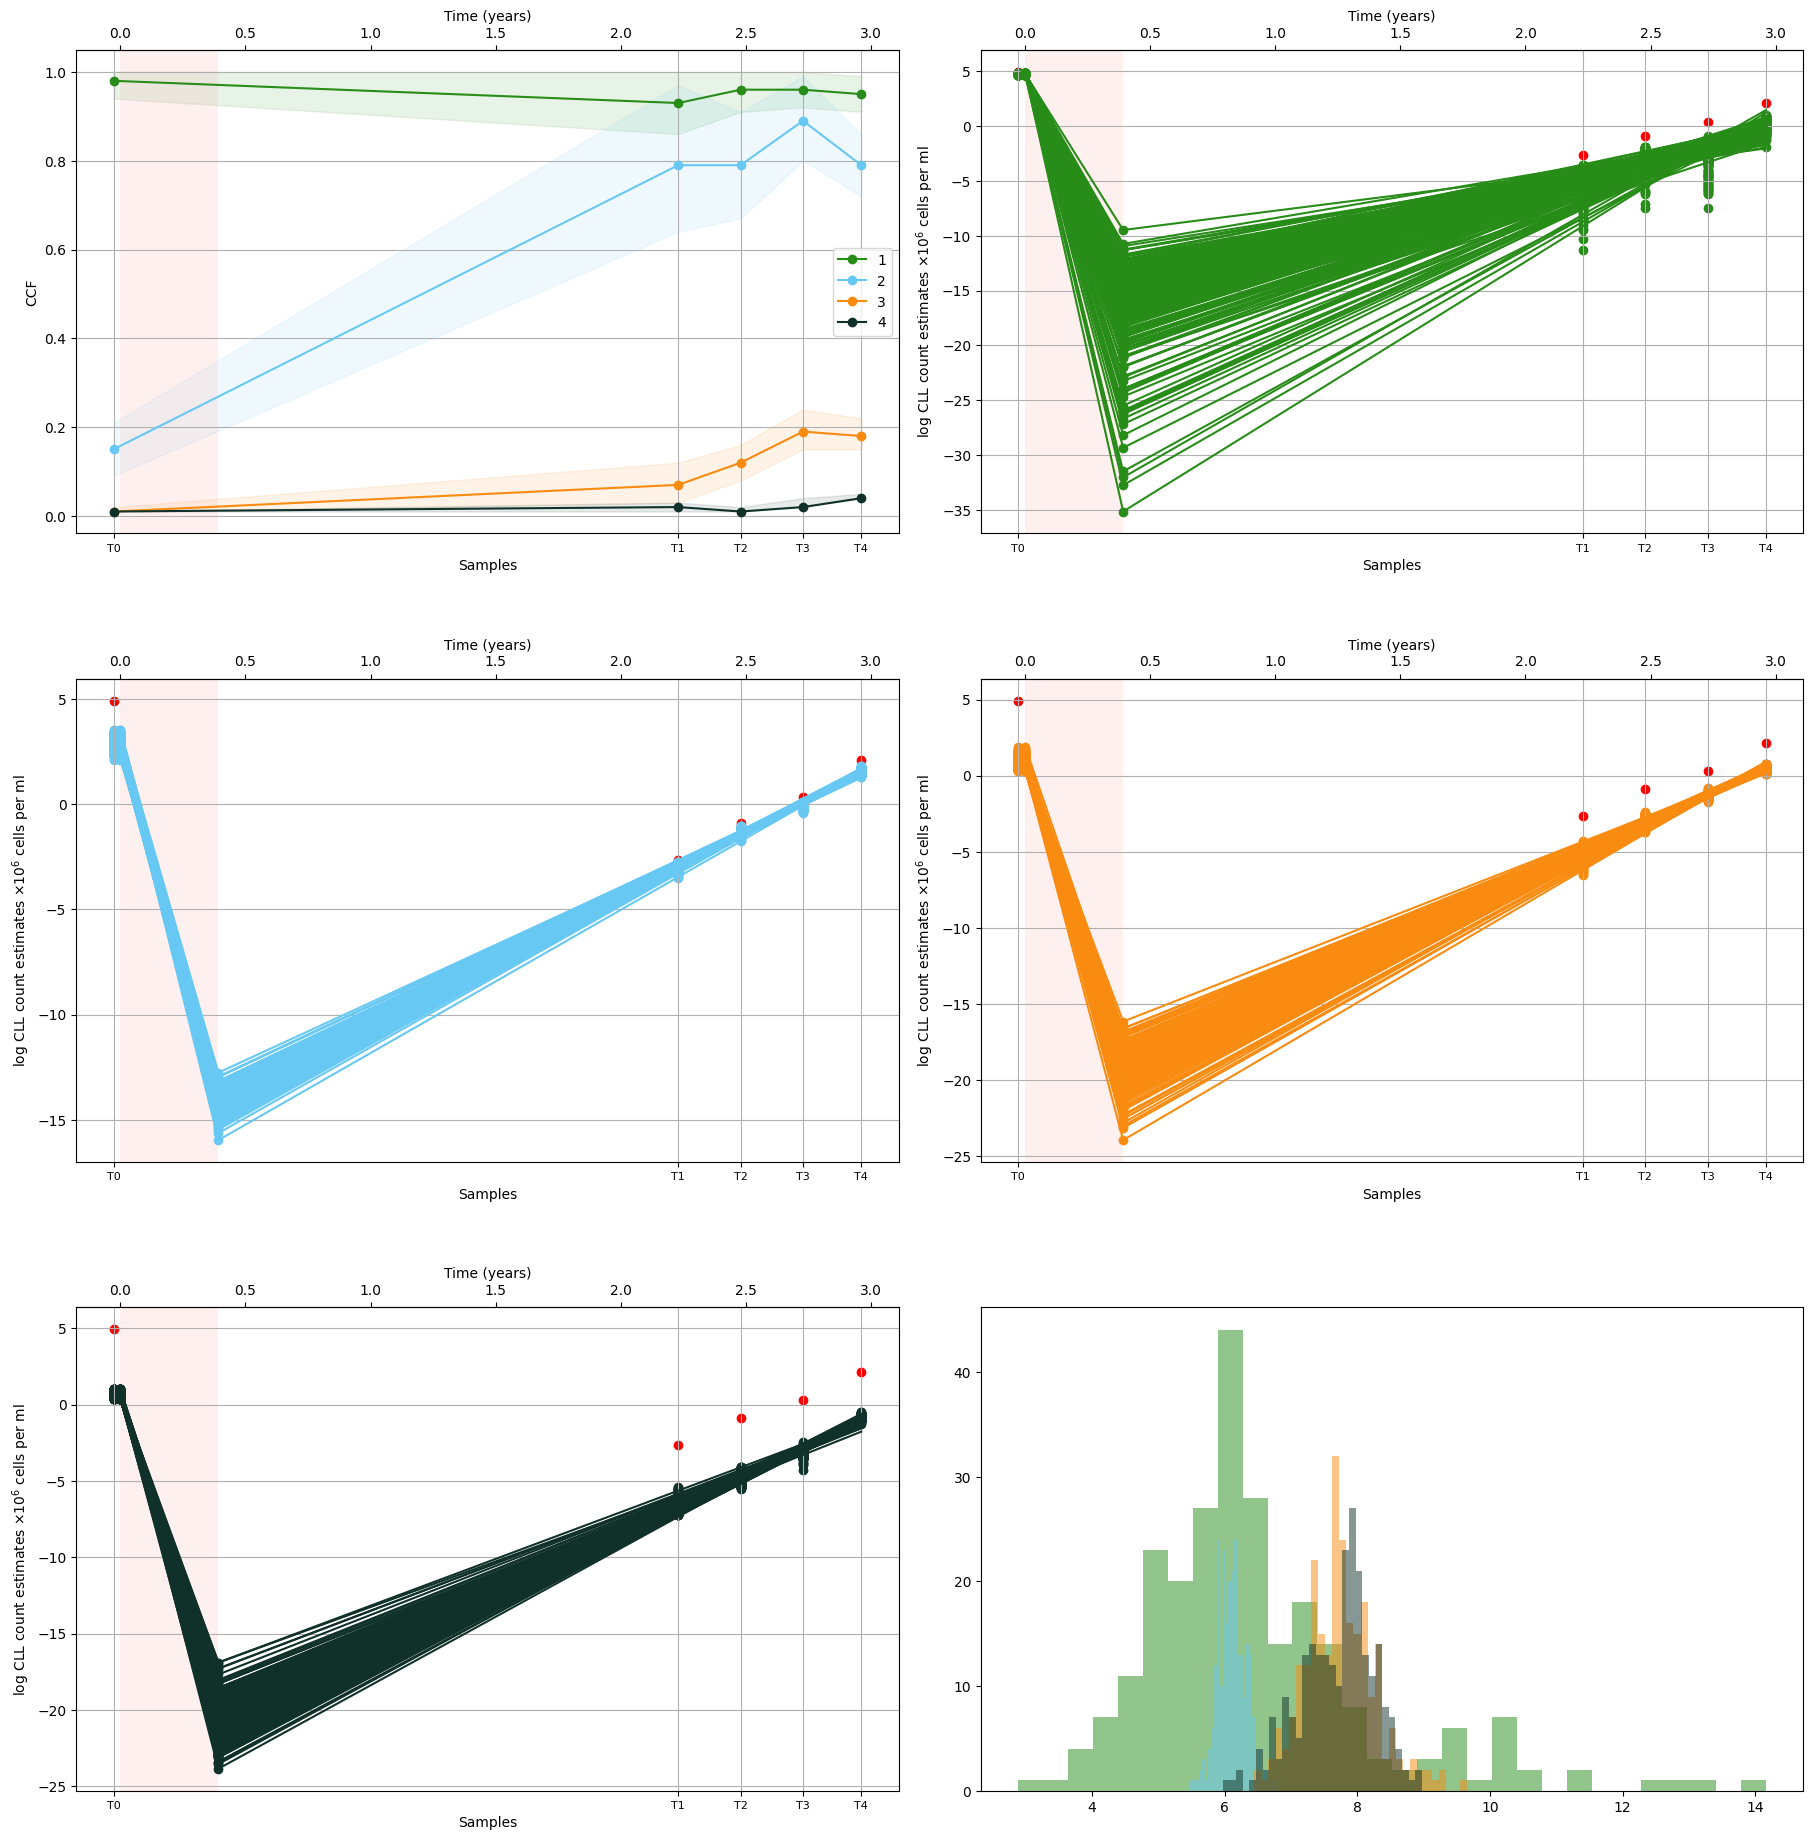

In [39]:
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(18,18))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]




slopes_mcmc = {}
def plot_sub_mcmc(ax, cluster):
    
        
    # plot total wbc
    
    x_year = [ i/365 for i in np.array(times_sample)]
    ax.scatter(x_year,np.log(CLL_count), label = 'CLL count estimate', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}
    
    
    slopes_mcmc[cluster]=[]
    for iter_idx in range(250):
        
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx])
        ax.scatter(x_year,y_sub,c= ClusterColors.get_hex_string(cluster),)


        # Extrapolate after treatment
        extrapolate_times = times_sample[extrapolate_start_idx:]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx][extrapolate_start_idx:]

        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)
        
        slopes_mcmc[cluster].append(model[0])
        

        predict_x = times_aft_tx
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        
        predicted_end_tx_clones.append(predicted[0])
        ax.plot(predict_year, predicted, color=ClusterColors.get_hex_string(cluster))


        times_during_tx = [0,143/365]

       

        tx_start_clones = log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx][0]

        
        ax.plot(times_during_tx, [tx_start_clones, predicted[0]], color=ClusterColors.get_hex_string(cluster), marker = 'o')

        
    


    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log CLL count estimates $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_sub_mcmc(ax2, 1)
plot_sub_mcmc(ax3, 2)
plot_sub_mcmc(ax4, 3)
plot_sub_mcmc(ax5, 4)
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


for cluster in clusters:
    ax6.hist(slopes_mcmc[cluster], alpha=0.5,color=ClusterColors.get_hex_string(cluster), bins = 30)


In [40]:
for cluster in clusters:
    mean = np.mean(slopes_mcmc[cluster], axis=0)
    lower_ci = np.percentile(slopes_mcmc[cluster], 2.5, axis=0)
    upper_ci = np.percentile(slopes_mcmc[cluster], 97.5, axis=0)
    print(f"Cluster: {cluster}, mean:{mean:.4f}, 95% Confidence Interval: {lower_ci:.4f} to {upper_ci:.4f}")
    
    

Cluster: 1, mean:6.4944, 95% Confidence Interval: 4.0485 to 10.6277
Cluster: 2, mean:6.1115, 95% Confidence Interval: 5.6871 to 6.5379
Cluster: 3, mean:7.7489, 95% Confidence Interval: 6.7664 to 8.9611
Cluster: 4, mean:7.7015, 95% Confidence Interval: 6.5316 to 8.6562


In [41]:
# Adopt the CRC model 

from scipy.special import logsumexp 
from scipy.optimize import minimize

class MultiClusterLinearRegression:
    def __init__(self, n_clusters,X, y):
        self.n_clusters = n_clusters
        self.params = None
        self.X = X
        self.y = y
        
        
    def calculate_weight_ratio(self ):
        num_wbc = len(self.y)
        num_exomes = sum(1 for item in self.y if item is not None)
        
        weight_ratio = num_wbc / ((num_exomes)*(self.n_clusters -1))
        return weight_ratio
        

    def objective(self, params, logsumexp_points, ):
        # reshape params into intercepts and slopes
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]

        weight_ratio = self.calculate_weight_ratio()
        
        # calculate predicted y values for all clusters 
        y_pred = np.outer(self.X, slopes) + intercepts

        # Calcualte negative log-likelihood
        likelihood = 0

        # For exome points
        for i, yi in enumerate(self.y):
   
            if yi is not None:
                likelihood +=  weight_ratio * np.sum((yi - y_pred[i])**2)

        # For logsumexp points
        
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood += (lse - logsumexp(y_pred[i]))**2

        return likelihood  # We minimize negative log-likelihood



    def fit(self, logsumexp_points, initial_guess = None):

        if initial_guess is None:
            initial_guess = np.random.randn(2 * self.n_clusters)

        result = minimize(
            self.objective, 
            initial_guess,
            args = (logsumexp_points),
            method = 'SLSQP'
        )

        self.params = result.x 




        
        
    def calculate_likelihood(self, params, logsumexp_points):
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]
        y_pred = np.outer(self.X, slopes) + intercepts
        
        likelihood_y = 0
        for i, yi in enumerate(self.y):
            if yi is not None:
                likelihood_y += np.sum((yi - y_pred[i])**2)
                print(f"exome logsubclone: {yi},exome predicted: {y_pred[i]}, likelihood_y: {likelihood_y}")
        
       
        print(f"squared sum_y: {likelihood_y}")
        
        
        likelihood_logsumexp = 0 
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood_logsumexp += (lse - logsumexp(y_pred[i]))**2
                print(f"log wbc: {lse},wbc predicted: {logsumexp(y_pred[i])}")
        print(f"squared sum_logsumexp: {likelihood_logsumexp}")
        
        total_squared_sum = likelihood_y + likelihood_logsumexp
    
        print(f"total squared sum: {total_squared_sum}")
        return likelihood_y, likelihood_logsumexp
    


    def predict(self,):
        intercepts = self.params[:self.n_clusters]
        slopes = self.params[self.n_clusters:]
        return np.outer(self.X, slopes) + intercepts
    



In [42]:
def create_inputs(times_sliced, log_subclone_sample_mcmc,iter, index_samples_model):
    
    X = [ i/365 for i in np.array(times_sliced)]
    
    
    # reconstruct the dictionary so that {iteration number: cluster number :[time]}
    log_subclone_cluster_iter = {}
    
    # Iterate through each cluster
    for cluster, iterations in log_subclone_sample_mcmc.items():
        # Iterate through each iteration in the cluster
        for iteration, value in iterations.items():
            # If the iteration is not in the new dict, add it
            if iteration not in log_subclone_cluster_iter:
                log_subclone_cluster_iter[iteration] = {}
            # Add the cluster and its value to this iteration
            log_subclone_cluster_iter[iteration][cluster] = value
    
    
    
    values = list(log_subclone_cluster_iter[iter].values())
    array = np.array(values)
    array_trans = array.T
    selected_sample = array_trans[index_samples_model]
    
    
    times_sample_selected = times_sample[index_samples_model]
    indices = [i for i, x in enumerate(times_sliced) if x in times_sample_selected]
    
    y = [None] * len(times_sliced)
    i = 0
    # Fill the rows that correspond with the exome points
    for index in indices: 
        y[index] = selected_sample[i]
        i +=1
    
    
    return X, y
    

In [44]:
# Convert the column "CLL count estm" to float 
wbc_df_0068['CLL count estm'] = wbc_df_0068['CLL count estm'].astype(float)

/var/folders/x6/7zg8fddx4dlgx2lv4sv34_g40000gp/T/ipykernel_35402/2206078020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wbc_df_0068['CLL count estm'] = wbc_df_0068['CLL count estm'].astype(float)


In [45]:
 
times_sliced_aft = [int(i) for i in wbc_df_0068[wbc_df_0068['CLL count estm'] > 0]['Time_since_start_tx'].values  if int(i) > 0]

In [47]:
wbc_df_0068

,Pt no.,Patient,Date of diagnosis,Date of treatment,Date of sample,Time_since_start_tx,WBC,MRD,MRD negative,CLL count estm,Timepoint,Sample
178,17.0,GCLL-0068,1/16/06,3/6/06,2/24/06,-10,150.00,0.9300000000,0.0,139.500000,GCLL-0068-T-01,CLL-GCLL-0068-Tumor-SM-41JNW
179,17.0,GCLL-0068,1/16/06,3/6/06,8/30/06,177,4.60,0.0003558194,0.0,0.001637,NaN,NaN
180,17.0,GCLL-0068,1/16/06,3/6/06,10/25/06,233,4.60,0.0003043626,0.0,0.001400,NaN,NaN
181,17.0,GCLL-0068,1/16/06,3/6/06,1/17/07,317,4.60,0.0004219766,0.0,0.001941,NaN,NaN
182,17.0,GCLL-0068,1/16/06,3/6/06,4/25/07,415,4.60,0.0003381446,0.0,0.001555,NaN,NaN
183,17.0,GCLL-0068,1/16/06,3/6/06,7/18/07,499,4.60,0.0003202193,0.0,0.001473,NaN,NaN
184,17.0,GCLL-0068,1/16/06,3/6/06,10/24/07,597,4.60,0.0008395211,0.0,0.003862,NaN,NaN
185,17.0,GCLL-0068,1/16/06,3/6/06,1/16/08,681,4.60,0.0025207700,0.0,0.011596,NaN,NaN
186,17.0,GCLL-0068,1/16/06,3/6/06,5/28/08,814,4.60,0.0150721739,0.0,0.069332,GCLL-0068-MRD-01,CLL-GCLL-0068-Tumor-SM-7C9BS
187,17.0,GCLL-0068,1/16/06,3/6/06,8/27/08,905,5.10,0.0804458289,0.0,0.410274,GCLL-0068-MRD-02,CLL-GCLL-0068-Tumor-SM-7C9BT


In [46]:
times_sliced_aft

[177, 233, 317, 415, 499, 597, 681, 814, 905, 996, 1081]

In [48]:
wbc_guess= np.linspace(3, 4.6, 8)

In [49]:
wbc_guess

array([3.        , 3.22857143, 3.45714286, 3.68571429, 3.91428571,
       4.14285714, 4.37142857, 4.6       ])

In [57]:
CLL_guess = [0.00106746,
0.00098248,
0.00145877,
0.00124630,
0.00125334,
0.00347562,
0.01093258,
0.06933200,
0.41027373,
1.39188415,
8.33490000]

In [62]:
log_subclone_sample_mcmc_with_uniform_noise[1]

{0: [4.7924964163723205,
  -4.6566521552811695,
  -2.592303068312471,
  -1.342035726082029,
  0.7553194575324003],
 1: [4.771580517932314,
  -7.2686212879550895,
  -4.062752409703633,
  -4.6217224420784175,
  0.6517783977325883],
 2: [4.781883255888749,
  -9.49725575513063,
  -2.6417587559282256,
  -1.589344802948198,
  0.7336119720262836],
 3: [4.709714371682158,
  -5.44830263186595,
  -3.3340791163651367,
  -1.0629692319755493,
  -0.2962857786795162],
 4: [4.74524423641048,
  -4.274469893214075,
  -2.5164063338657927,
  -2.0778951279742977,
  0.17860718275030377],
 5: [4.7789673885996615,
  -9.389048354461982,
  -2.1844151622180057,
  -2.1781352742152342,
  -0.7443740400410195],
 6: [4.720549255659409,
  -4.317393348874723,
  -2.9000477363007198,
  -1.8456667922597034,
  0.6769545166013432],
 7: [4.811838987421796,
  -4.32767853471155,
  -3.9230547386294736,
  -1.8886714667873932,
  -0.040017114770557],
 8: [4.753334961162774,
  -4.105669425801847,
  -3.1892769427753,
  -1.8607132554

In [58]:
n_clusters = 4

X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc_with_uniform_noise,1, slice(1,5))

logsumexp_points = np.log(CLL_guess)

In [59]:
model = MultiClusterLinearRegression(n_clusters, X, y)
model.fit(logsumexp_points)
logsumexp_points_model = [logsumexp(yi) for yi in model.predict()]

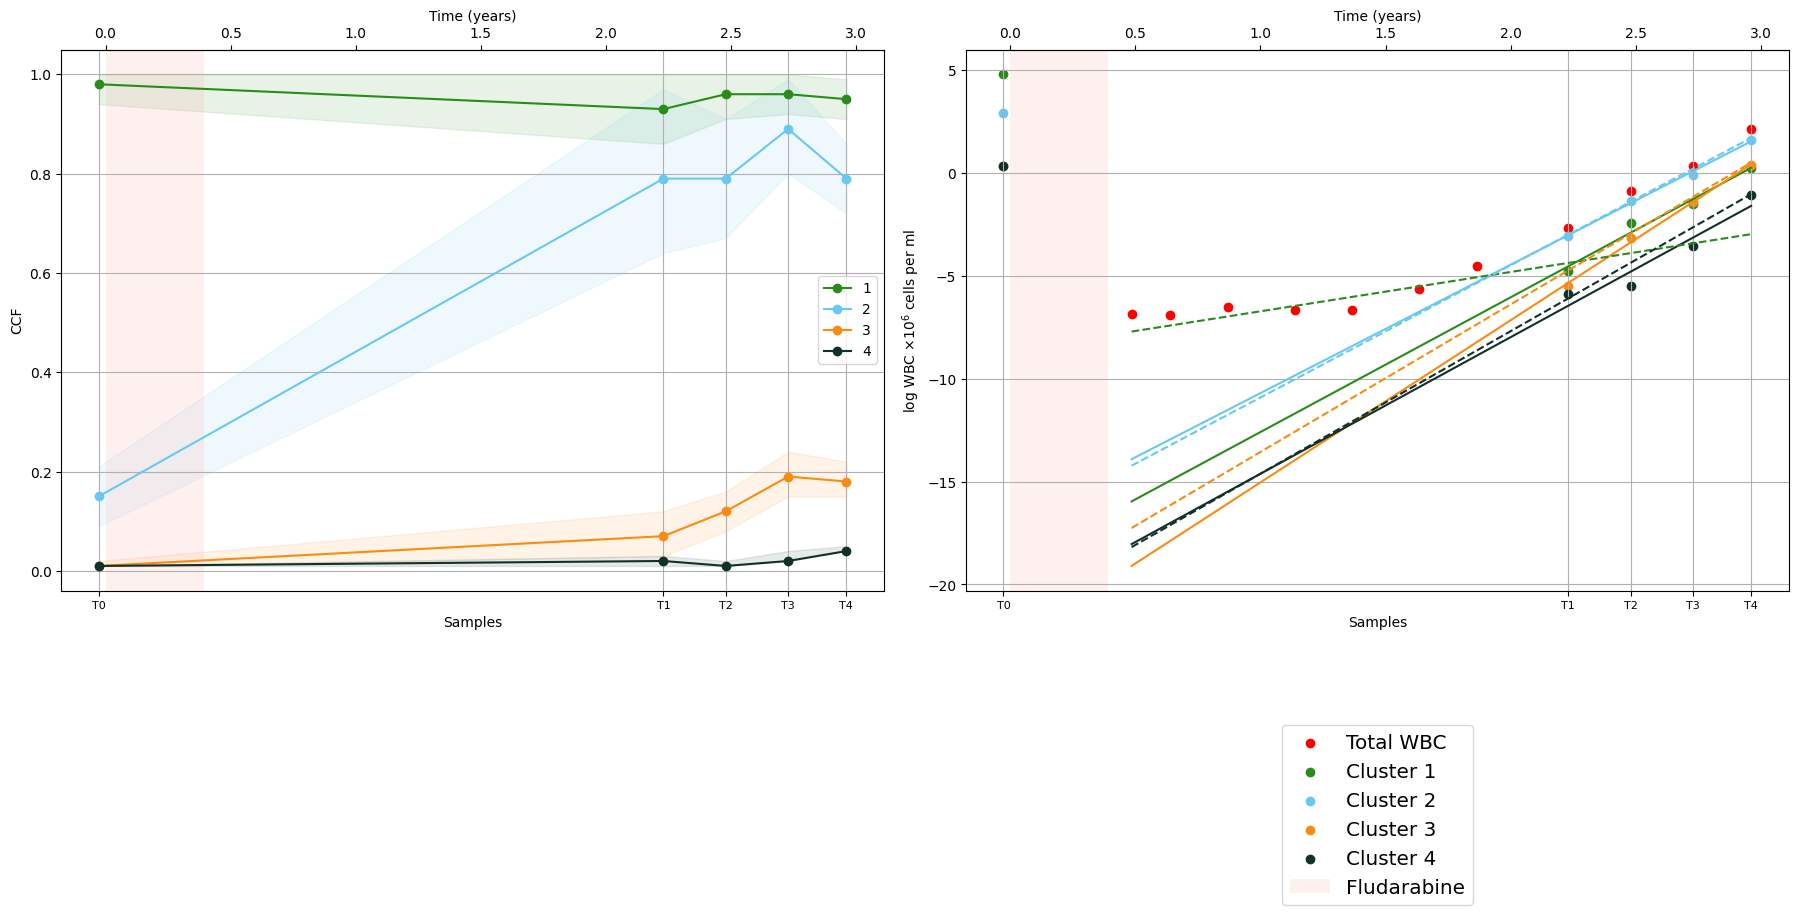

In [60]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_model_single_iter(ax, clusters, extrapolate_start_idx,model):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_sliced_aft)]
    ax.scatter(x_year_selected,np.log(CLL_guess), label = 'Total WBC', c = 'red')

    # plot subclones

    cluster_cell_population = {}

    
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)


        # Extrapolate after treatment
        
  
        extrapolate_times =times_sample[extrapolate_start_idx:]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        

        extrapolate_subclone = log_subclone_sample[i][extrapolate_start_idx:]
        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_sliced_aft
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))



        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential

    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
    # plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)
            

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')
    
    
    
    

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

extrapolate_start_idx =1
plot_model_single_iter(ax2, [1,2,3, 4], extrapolate_start_idx,model)
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


for i in [1,2,3,4]:

    ax2.plot(X,model.predict()[:,i-1], '--', color=ClusterColors.get_hex_string(i))
# ax2.scatter(X, logsumexp_points_model,marker='^')

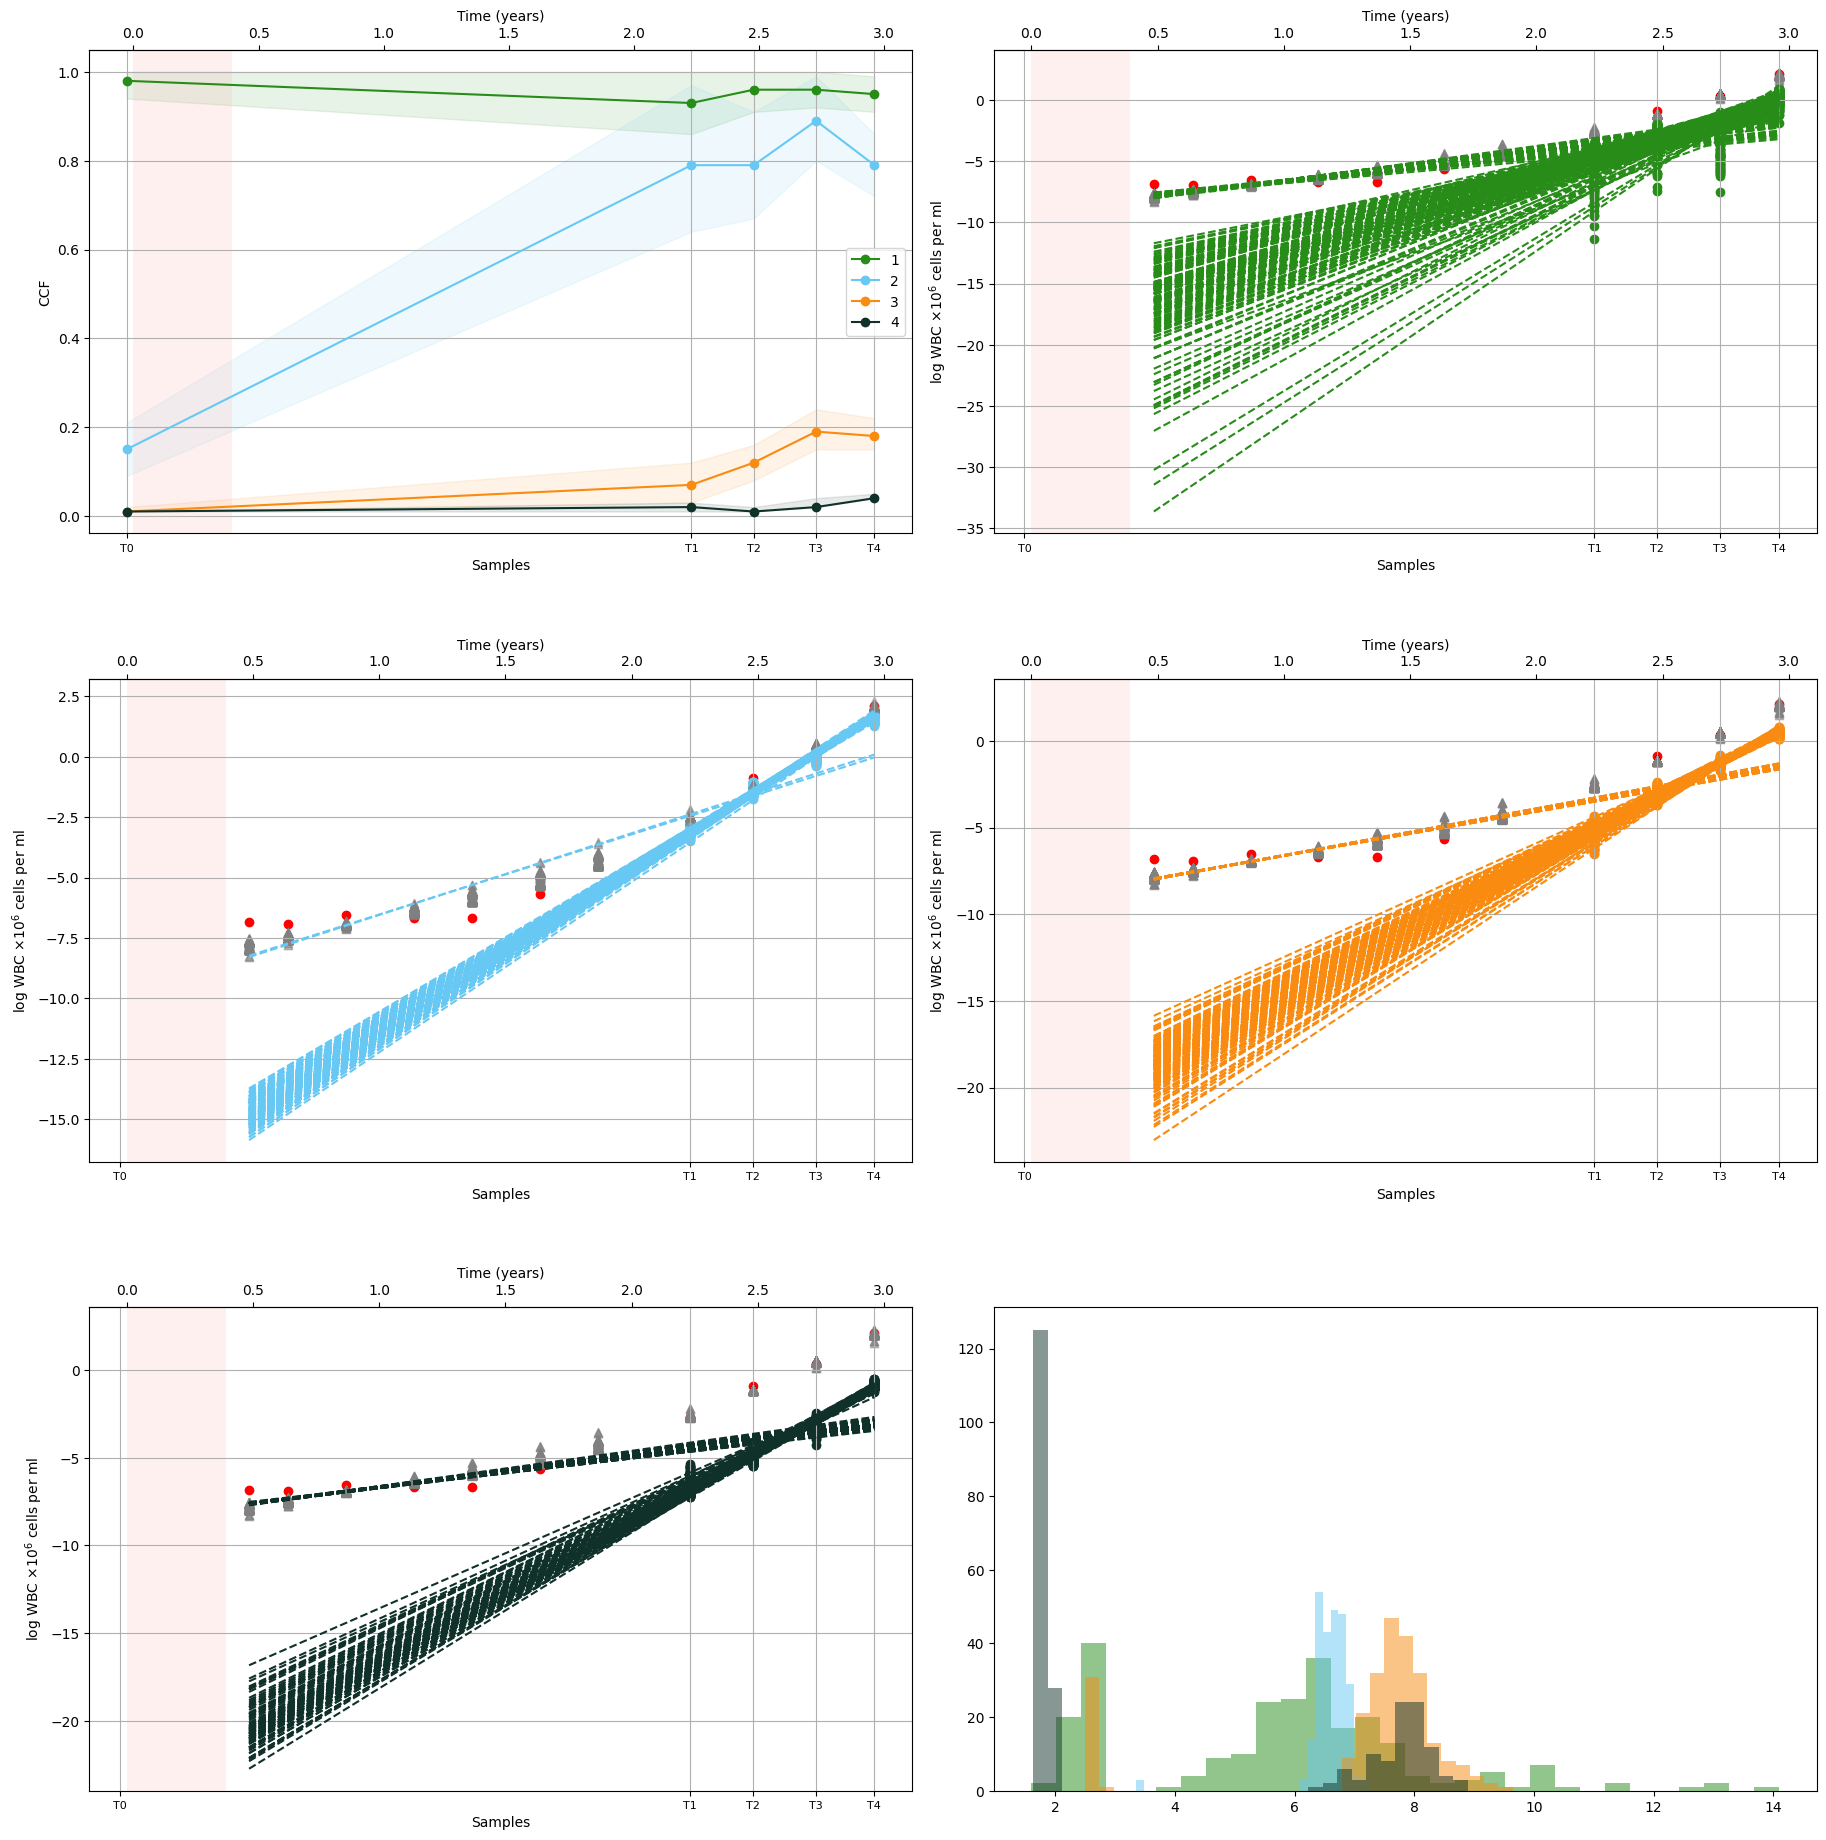

In [54]:
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(18,18))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]



slopes_mcmc = {}
def plot_mcmc_model(ax, cluster, n_clusters,index_samples_model, ):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_sliced_aft)]
    ax.scatter(x_year_selected,np.log(CLL_guess), label = 'Total WBC', c = 'red')

    

    

    # Extrapolate after treatment 
    cluster_cell_population = {}


    # store the weights in a dictionary 
    
#     slopes_mcmc[cluster]=[]
    for iter_idx in range(250):
        
        
        # plot subclones
        x_year = [ i/365 for i in np.array(times_sample)][1:]
        y_sub = np.array(log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx])[1:]
        ax.scatter(x_year,y_sub,c= ClusterColors.get_hex_string(cluster),)
        
        
        X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc_with_uniform_noise,iter_idx, index_samples_model)
        
        logsumexp_points = np.log(CLL_guess)

        # for every mcmc iteration, we create a model
        model = MultiClusterLinearRegression(n_clusters, X, y)


        
        model.fit(logsumexp_points )
        
        
        slopes_mcmc[iter_idx] = model.params[n_clusters:]  
#         slopes_mcmc[cluster].append(model[0])

        ax.plot(X,model.predict()[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
        


        logsumexp_points_model = [logsumexp(yi) for yi in model.predict()]
        
        # ax.plot(predict_year,model.predict(predict_year)[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            
        ax.scatter(X, logsumexp_points_model,marker='^', color = 'grey', alpha = 0.5)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    


model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_mcmc_model(ax2, 1, n_clusters = 4, index_samples_model = slice(1,5), )
plot_mcmc_model(ax3, 2, n_clusters = 4, index_samples_model = slice(1,5), )
plot_mcmc_model(ax4, 3, n_clusters = 4, index_samples_model = slice(1,5), )
plot_mcmc_model(ax5, 4, n_clusters = 4, index_samples_model = slice(1,5), )

ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


slopes_mcmc_transposed = {col: np.array([slopes_mcmc[row][col] for row in slopes_mcmc]) for col in range(len(slopes_mcmc[0]))}    
for cluster in range(n_clusters):
    ax6.hist(slopes_mcmc_transposed[cluster], alpha=0.5,color=ClusterColors.get_hex_string(cluster+1), bins = 30)



In [55]:
clusters = [1,2,3,4]
for cluster in clusters:
    mean = np.mean(slopes_mcmc_transposed[cluster-1], axis=0)
    lower_ci = np.percentile(slopes_mcmc_transposed[cluster-1], 2.5, axis=0)
    upper_ci = np.percentile(slopes_mcmc_transposed[cluster-1], 97.5, axis=0)
    print(f"Cluster: {cluster}, mean:{mean:.4f}, 95% Confidence Interval: {lower_ci:.4f} to {upper_ci:.4f}")

Cluster: 1, mean:5.7280, 95% Confidence Interval: 2.1320 to 10.4470
Cluster: 2, mean:6.5872, 95% Confidence Interval: 6.2366 to 6.9975
Cluster: 3, mean:7.1325, 95% Confidence Interval: 2.5756 to 8.9360
Cluster: 4, mean:4.1372, 95% Confidence Interval: 1.7193 to 8.4539


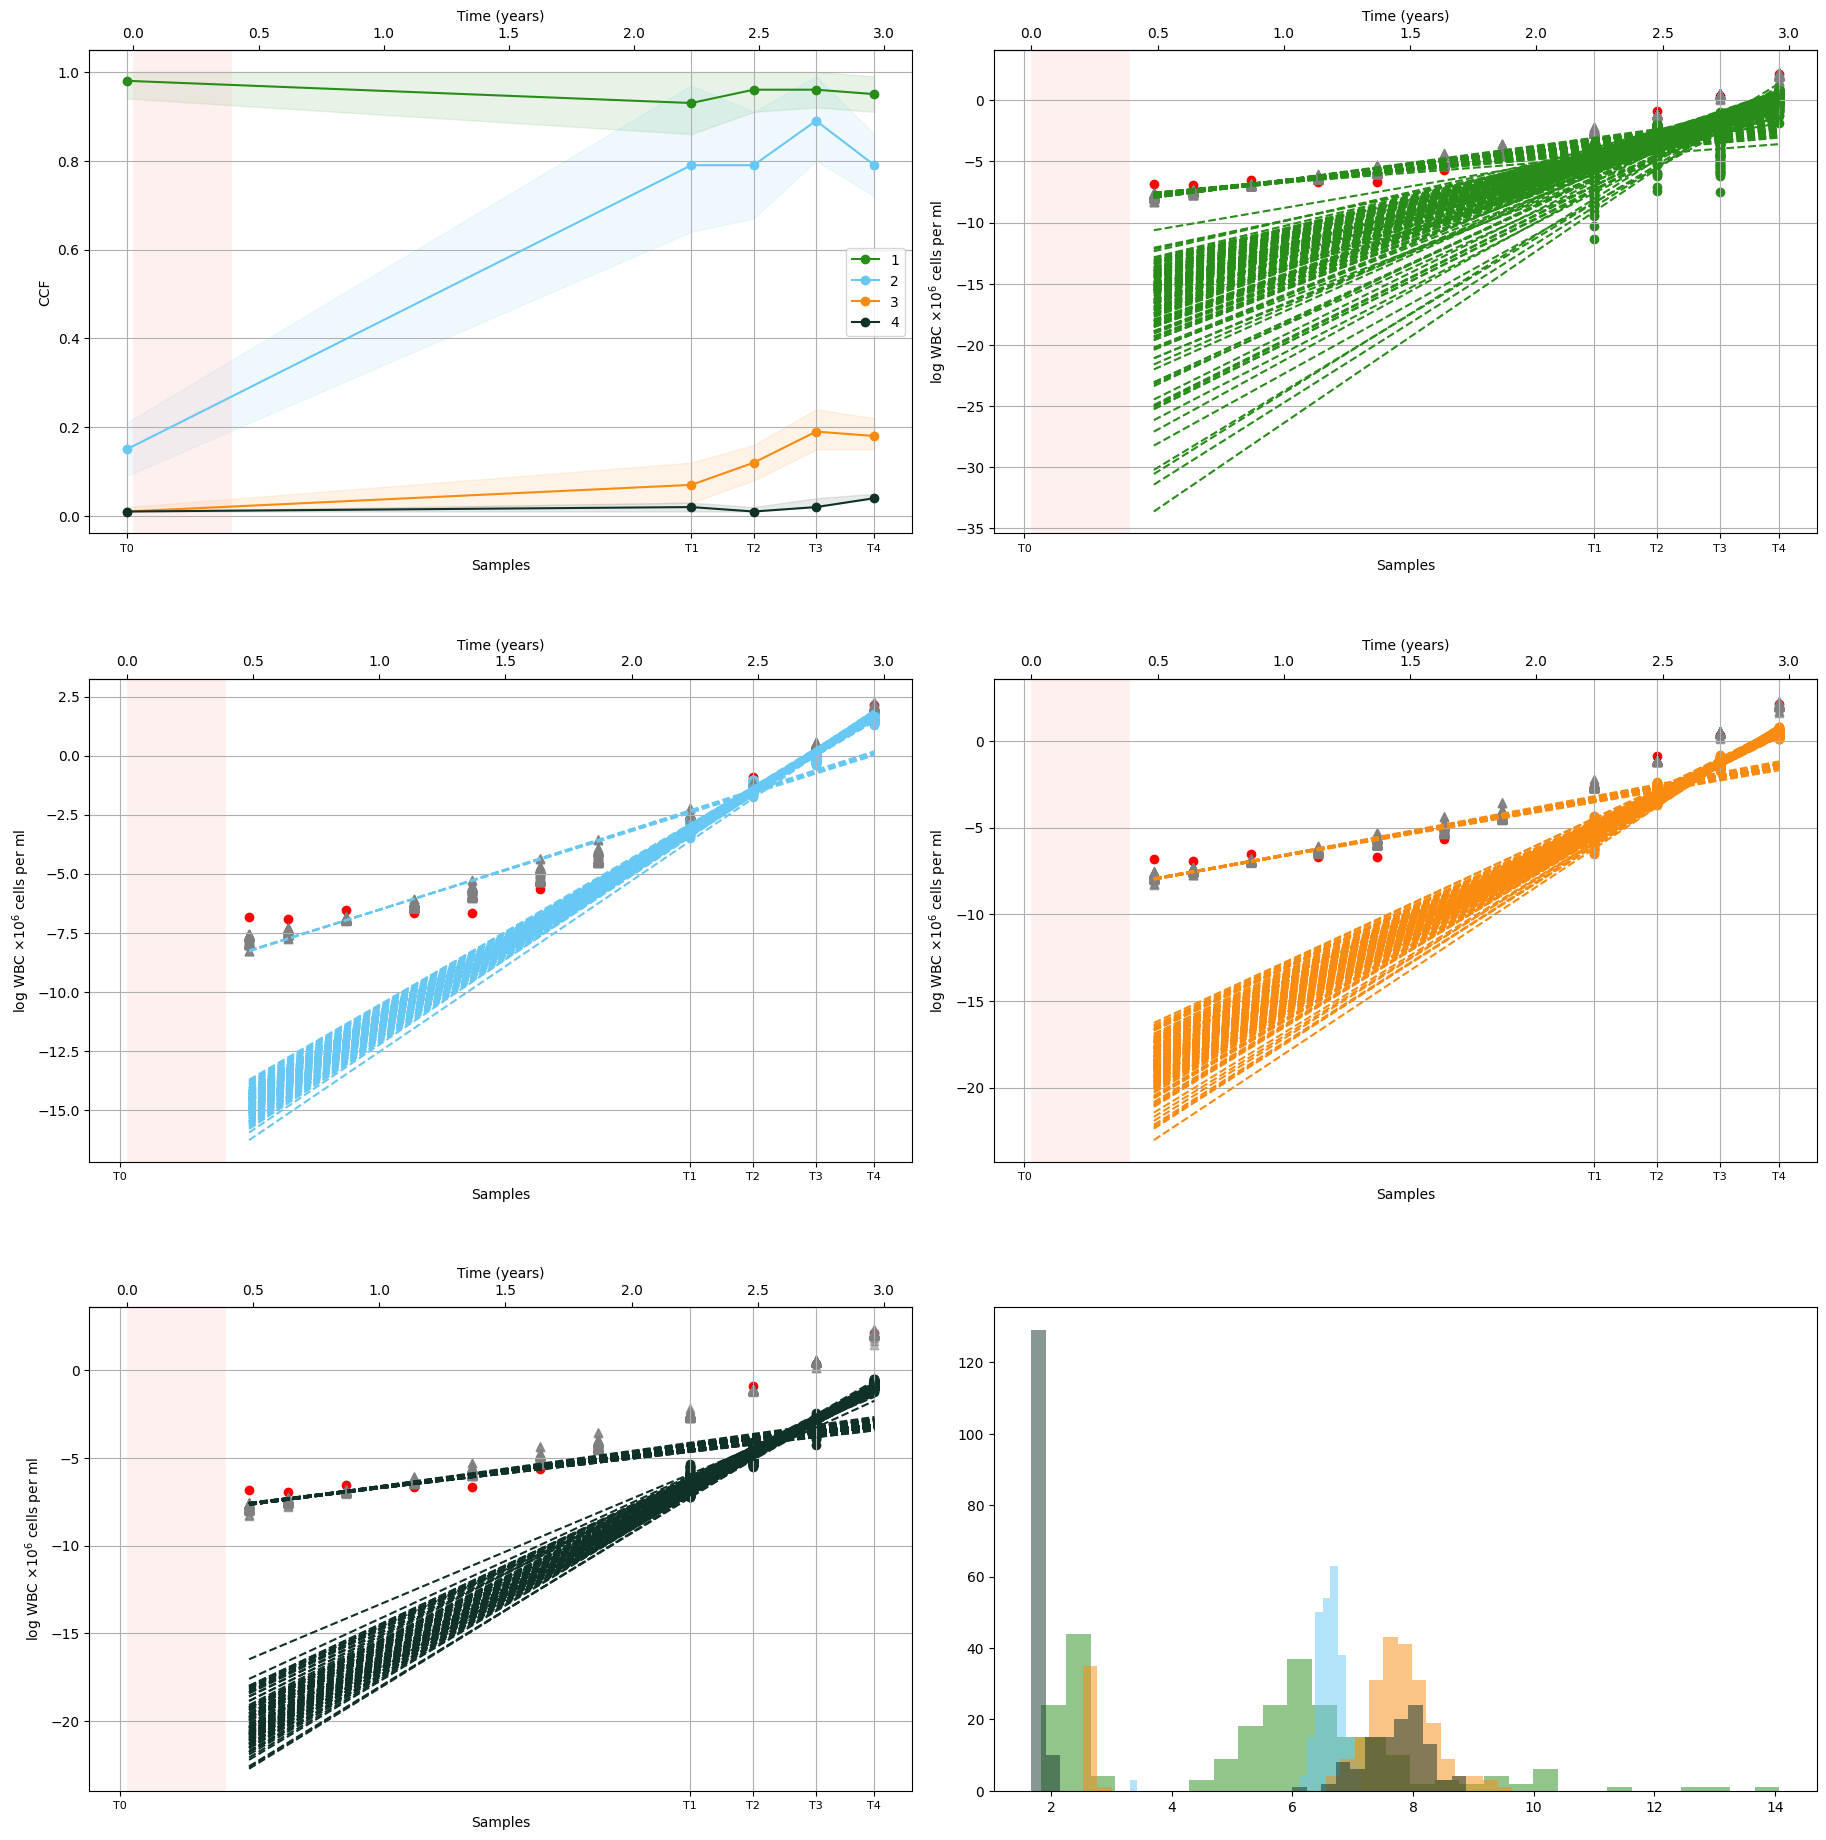

In [56]:
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(18,18))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]



slopes_mcmc = {}
def plot_mcmc_model(ax, cluster, n_clusters,index_samples_model, ):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_sliced_aft)]
    ax.scatter(x_year_selected,np.log(CLL_guess), label = 'Total WBC', c = 'red')

    

    

    # Extrapolate after treatment 
    cluster_cell_population = {}


    # store the weights in a dictionary 
    
#     slopes_mcmc[cluster]=[]
    for iter_idx in range(250):
        
        
        # plot subclones
        x_year = [ i/365 for i in np.array(times_sample)][1:]
        y_sub = np.array(log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx])[1:]
        ax.scatter(x_year,y_sub,c= ClusterColors.get_hex_string(cluster),)
        
        
        X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc_with_uniform_noise,iter_idx, index_samples_model)
        
        logsumexp_points = np.log(CLL_guess)

        # for every mcmc iteration, we create a model
        model = MultiClusterLinearRegression(n_clusters, X, y)


        
        model.fit(logsumexp_points )
        
        
        slopes_mcmc[iter_idx] = model.params[n_clusters:]  
#         slopes_mcmc[cluster].append(model[0])

        ax.plot(X,model.predict()[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            


        logsumexp_points_model = [logsumexp(yi) for yi in model.predict()]
        
        # ax.plot(predict_year,model.predict(predict_year)[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            
        ax.scatter(X, logsumexp_points_model,marker='^', color = 'grey', alpha = 0.5)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    


model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_mcmc_model(ax2, 1, n_clusters = 4, index_samples_model = slice(1,5), )
plot_mcmc_model(ax3, 2, n_clusters = 4, index_samples_model = slice(1,5), )
plot_mcmc_model(ax4, 3, n_clusters = 4, index_samples_model = slice(1,5), )
plot_mcmc_model(ax5, 4, n_clusters = 4, index_samples_model = slice(1,5), )

ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


slopes_mcmc_transposed = {col: np.array([slopes_mcmc[row][col] for row in slopes_mcmc]) for col in range(len(slopes_mcmc[0]))}    
for cluster in range(n_clusters):
    ax6.hist(slopes_mcmc_transposed[cluster], alpha=0.5,color=ClusterColors.get_hex_string(cluster+1), bins = 30)

